# Programación MINLP Ejemplo de Grossmann
### Elaborado por Daniel Ovalle - 201631778
### Asesorado por Jorge Mario Gómez y Camilo Gómez

El objetivo de este notebook es abordar el problema de pooling que expone Grossmann desde la formulación MINLP.

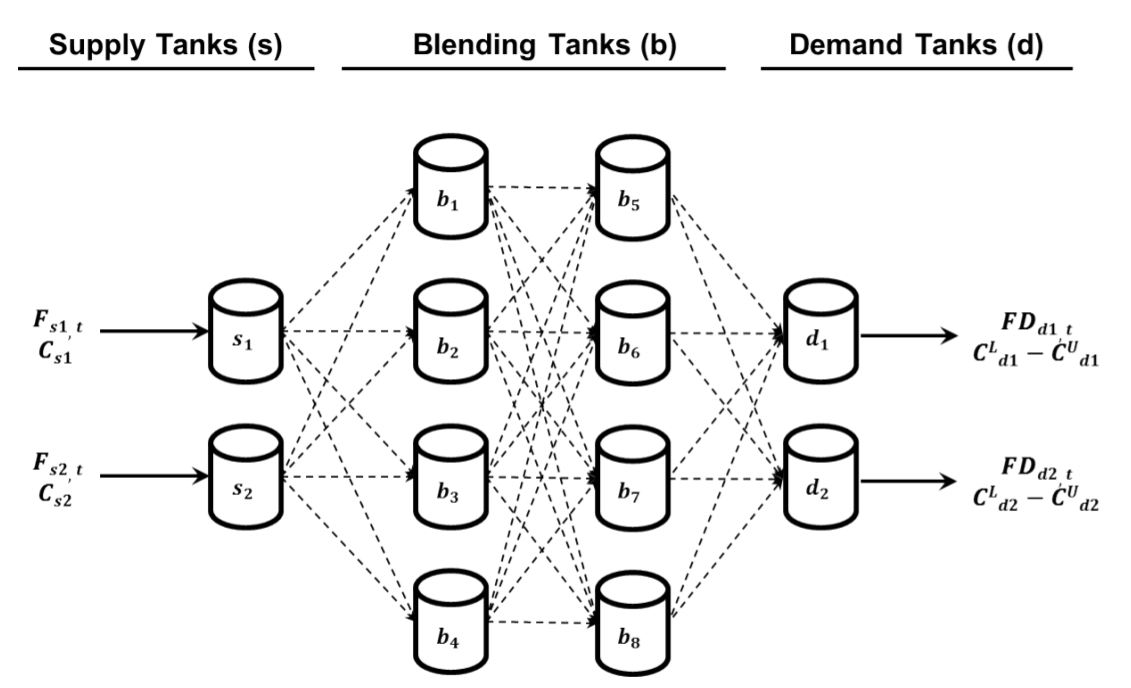

### Sets:
$N=$ Total number of tanks <br>
$A=$ Total number of feasible arcs <br>
$B=$ Blending tanks <br>
$S=$ Supply tanks <br>
$D=$ Demand tanks <br>
$Q=$ Specifications <br>
$T=$ Time periods <br>

### Continuous Variables: 
$F_{nn',t}=$ Flow between tanks $n$ and $n'$ at the end of time $t$<br>
$FD_{d,t}=$ Demand flow from tanks $d$ at time $t$ <br>
$I_{n,t}=$ Inventory in tank $n$ at the end of time $t$ <br>
$C_{q,b,t}=$ Specification $q$ in tank $b$ at the end of time $t$ <br>

### Binary Variables:
$X_{nn',t}=$ Indicates the existence of flow between tanks $n$ and $n'$ at the end of time $t$ <br>

### Parameters:
$I^0_n=$ Initial inventory for tank $n$ <br>
$C^0_{q,b}=$ Initial values for the specifications $q$ in tank $b$ <br>
$F^{IN}_{s,t}=$ Incoming supply flows enter tank $s$ at time $t$ <br>
$C^{IN}_{q,s}=$ Specification $q$ in supply flow to tank $s$ <br>
$\hat{C}^0_{q,r}$ Specification $q$ in source $r$ <br>
$[FD^L_{d,t} , FD^U_{d,t}]=$ Bounds on demand flow from tanks $d$ at time $t$ <br>
$[C^L_{q,d} , C^U_{q,d}]=$ Bounds on specification $q$ in demand tank $d$ <br>
$[I^L_n , I^U_n]=$ Bounds on inventory for tank $n$ <br>
$[F^L_{nn'} , F^U_{nn'}]=$ Bounds on flow between tank $n$ and $n'$ <br>
$\beta^T_s=$ Costs for the supply flow for tank $s$ <br>
$\beta^T_d=$ Prices for demand flow for tank $d$ <br>
$\alpha^N_{nn'}=$ Fixed costs for flow from tank $n$ to tnak $n'$ <br>
$\beta^N_{nn'}=$ Variable costs for flow from tank $n$ to tnak $n'$ <br>

In [1]:
# Import all

import numpy as np
import pandas as pd
import networkx as nx
from gurobipy import *
import matplotlib.pyplot as plt
import time as time
import random as random

In [2]:
# Create Sets
B = [3,4,5,6,7,8,9,10]
S = [1,2]
D = [11,12]
N = S + B + D

B1 = [3,4,5,6]
B2 = [7,8,9,10]
Nb = S + B1


Asn = {(s,n):1 for s in S for n in B1}
And = {(n,d):1 for n in B2 for d in D}
Abb = {(b1,b2):1 for b1 in B1 for b2 in B2}
Asd = {(s,d):1 for s in S for d in D}
A = {}
for i in (Asn, Abb, And, Asd): 
    A.update(i)
    
Anb ={}
for i in (Asn, Abb):
    Anb.update(i)
        
Q = ['A']
T = list(range(1,7))

BM = 30
BMC = 2
BM1 = 30
BM2 = BM

#Create given Parameters
I0_b = {b:0 for b in B}  
C0_qb = {(q,b):0 for q in Q for b in B}
IU_s = {s:0 for s in S}
IU_d = {d:0 for d in D}
IU_b1 = {b1:30 for b1 in B1}
IU_b2 = {b2:20 for b2 in B2}
IU_b = {}
for i in (IU_b1, IU_b2): 
    IU_b.update(i)
FU_nn = {nn:30 for nn in A}
alphaN_nn = {nn:0.1 for nn in A}
CIN_qs = {('A',1):0.06, ('A',2):0.26}
FIN_st = {(1,1):10, (1,2):10, (1,3):10, (1,4):0, (1,5):0, (1,6):0, (2,1):30, (2,2):30, (2,3):30, (2,4):0, (2,5):0, (2,6):0}
betaT_s = {s:0 for s in S}
CL_qd = {(q,d):0 for q in Q for d in D}
CU_qd = {('A',11):0.16, ('A',12):1}
FDL_dt = {(11,1):0, (11,2):0, (11,3):15, (11,4):15, (11,5):15, (11,6):15, (12,1):0, (12,2):0, (12,3):15, (12,4):15, (12,5):15, (12,6):15}
betaT_d = {11:2 , 12:1}

#Create other Parameters
I0_s = {s:0 for s in S}
I0_d = {d:0 for d in D}
I0_n = {}
for i in (I0_s, I0_b, I0_d): 
    I0_n.update(i)
FDU_dt = {(d,t):BM1 for d in D for t in T}
IL_n = {n:0 for n in N}
IU_n = {}
for i in (IU_s, IU_b, IU_d): 
    IU_n.update(i)
FL_nn = {nn:10 for nn in A}
betaN_nn = {nn:0 for nn in A}
CL_q = {q:0 for q in Q}
CU_q = {q:1 for q in Q}


R = S
C0hat_qr = CIN_qs
for n in B:
    if I0_n[n] != 0:
        R.append(n)
        
for q in Q:
    for n in B:
        if I0_n[n] != 0:
            C0hat_qr.update(C0_qb)



In [3]:
BM = Fmax
BMC = 1
BM1 = Fmax
BM2 = Fmax

R = S
C0hat_qr = CIN_qs
for n in B:
    if I0_n[n] != 0:
        R.append(n)
        
for q in Q:
    for n in B:
        if I0_n[n] != 0:
            C0hat_qr.update(C0_qb)

# Model
m1 = Model("T3SD1Q1P12-RC (G0)")
m1.setParam('OutputFlag', 1)
m1.setParam('NonConvex', 2)
m1.setParam('TimeLimit', 20)
m1.setParam('MIQCPMethod', 0)
m1.setParam('MIPGap', 0.0001)

# Variables
F = {(nn,t):m1.addVar(vtype=GRB.CONTINUOUS,name="F_"+str((nn,t))) for nn in A for t in T}
FD = {(d,t):m1.addVar(vtype=GRB.CONTINUOUS,name="FD_"+str((d,t))) for d in D for t in T}
I = {(n,t):m1.addVar(vtype=GRB.CONTINUOUS,name="I_"+str((n,t))) for n in N for t in T}
C = {(q,b,t):m1.addVar(vtype=GRB.CONTINUOUS,name="C_"+str((q,b,t))) for q in Q for b in B for t in T}
X = {(nn,t):m1.addVar(vtype=GRB.BINARY,name="X_"+str((nn,t))) for nn in A for t in T}
YB = {(b,t):m1.addVar(vtype=GRB.BINARY,name="YB_"+str((b,t))) for b in B for t in T}

# Redundant Variables
Ftil = {(r,nn,t):m1.addVar(vtype=GRB.CONTINUOUS,name="Ftil_"+str((r,nn,t))) for r in R for nn in A for t in T}
Itil = {(r,b,t):m1.addVar(vtype=GRB.CONTINUOUS,name="Itil_"+str((r,b,t))) for r in R for b in B for t in T}


for t in T:
    for s in S: 
        if t==1:
            m1.addConstr(I[s,t] == I0_n[s] + FIN_st[s,t] - quicksum(F[(s,n),t] for n in B1) - quicksum(F[(s,d),t] for d in D))
        else:
            m1.addConstr(I[s,t] == I[s,t-1] + FIN_st[s,t] - quicksum(F[(s,n),t] for n in B1) - quicksum(F[(s,d),t] for d in D))
    

    for d in D: 
            if t==1:
                m1.addConstr(I[d,t] == I0_n[d] + quicksum(F[(n,d),t] for n in B2) + quicksum(F[(s,d),t] for s in S) - FD[d,t])
            else:
                m1.addConstr(I[d,t] == I[d,t-1] + quicksum(F[(n,d),t] for n in B2) + quicksum(F[(s,d),t] for s in S) - FD[d,t])
                
    for nn in A:
        m1.addConstr(F[nn,t] == quicksum(Ftil[r,nn,t] for r in R))
        
    for b in B:
        m1.addConstr(I[b,t] == quicksum(Itil[r,b,t] for r in R))

#___
    for n in S:
        for b in B1:
            m1.addConstr(FL_nn[(n,b)] - F[(n,b),t] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] - FU_nn[(n,b)] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] <= BM * X[(n,b),t])

    for n in B1:
        for b in B2:
            m1.addConstr(FL_nn[(n,b)] - F[(n,b),t] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] - FU_nn[(n,b)] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] <= BM * X[(n,b),t])
#___            
    for s in S:
        for d in D:
            m1.addConstr(FL_nn[(s,d)] - F[(s,d),t] <= BM * (1 - X[(s,d),t]))
            m1.addConstr(F[(s,d),t] - FU_nn[(s,d)] <= BM * (1 - X[(s,d),t]))
            m1.addConstr(F[(s,d),t] <= BM * X[(s,d),t])
            for q in Q:
                m1.addConstr(CL_qd[(q,d)] - CIN_qs[q,s] <= BMC * (1 - X[(s,d),t]))
                m1.addConstr(CIN_qs[q,s] - CU_qd[(q,d)] <= BMC * (1 - X[(s,d),t]))
                
#___           
    for b in B2:
        for d in D:
            m1.addConstr(FL_nn[(b,d)] - F[(b,d),t] <= BM * (1 - X[(b,d),t]))
            m1.addConstr(F[(b,d),t] - FU_nn[(b,d)] <= BM * (1 - X[(b,d),t]))
            m1.addConstr(F[(b,d),t] <= BM * X[(b,d),t])
            for q in Q:
                m1.addConstr(CL_qd[(q,d)] * F[(b,d),t] - quicksum(Ftil[r,(b,d),t] * C0hat_qr[q,r] for r in R) <= BM2 * (1 - X[(b,d),t]))
                m1.addConstr(quicksum(Ftil[r,(b,d),t] * C0hat_qr[q,r] for r in R) - CU_qd[(q,d)] * F[(b,d),t] <= BM2 * (1 - X[(b,d),t]))
                if t > 1:
                    m1.addConstr(CL_qd[(q,d)] - C[q,b,t-1] <= BMC * (1 - X[(b,d),t]))
                    m1.addConstr(C[q,b,t-1] - CU_qd[(q,d)] <= BMC * (1 - X[(b,d),t]))                   
                    m1.addConstr(CL_qd[(q,d)] * I[b,t-1] - quicksum(Itil[r,b,t-1] * C0hat_qr[q,r] for r in R) <= BM2 * (1 - X[(b,d),t]))
                    m1.addConstr(quicksum(Itil[r,b,t-1] * C0hat_qr[q,r] for r in R) - CU_qd[(q,d)] * I[b,t-1] <= BM2 * (1 - X[(b,d),t]))
#___
    for b in B1:
        if t==1:
            m1.addConstr(I[b,t] <= I0_n[b] + quicksum(F[(s,b),t] for s in S) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I0_n[b] + quicksum(F[(s,b),t] for s in S) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I0_n[b] - quicksum(F[(b,n),t] for n in B2) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I0_n[b] - quicksum(F[(b,n),t] for n in B2) - BM2 * YB[b,t])

        else:
            m1.addConstr(I[b,t] <= I[b,t-1] + quicksum(F[(s,b),t] for s in S) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I[b,t-1] + quicksum(F[(s,b),t] for s in S) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I[b,t-1] - quicksum(F[(b,n),t] for n in B2) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I[b,t-1] - quicksum(F[(b,n),t] for n in B2) - BM2 * YB[b,t])

                
        for q in Q:
            if t==1:
                m1.addConstr(I[b,t] * C[q,b,t] <= I0_n[b] * C0_qb[q,b] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I0_n[b] * C0_qb[q,b] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) - BM2 * (1 - YB[b,t]))
            else:
                m1.addConstr(I[b,t] * C[q,b,t] <= I[b,t-1] * C[q,b,t-1] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I[b,t-1] * C[q,b,t-1] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) - BM2 * (1 - YB[b,t]))
                m1.addConstr(C[q,b,t] <= C[q,b,t-1] + BMC * YB[b,t])
                m1.addConstr(C[q,b,t] >= C[q,b,t-1] - BMC * YB[b,t])
                
        for r in R:
            if t==1:
                m1.addConstr(Itil[r,b,t] <= I0_n[b] + quicksum(Ftil[r,(s,b),t] for s in S) + BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] >= I0_n[b] + quicksum(Ftil[r,(s,b),t] for s in S) - BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] <= I0_n[b] - quicksum(Ftil[r,(b,n),t] for n in B2) + BM2 * YB[b,t])
                m1.addConstr(Itil[r,b,t] >= I0_n[b] - quicksum(Ftil[r,(b,n),t] for n in B2) - BM2 * YB[b,t])
            else:
                m1.addConstr(Itil[r,b,t] <= Itil[r,b,t-1] + quicksum(Ftil[r,(s,b),t] for s in S) + BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] >= Itil[r,b,t-1] + quicksum(Ftil[r,(s,b),t] for s in S) - BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] <= Itil[r,b,t-1] - quicksum(Ftil[r,(b,n),t] for n in B2) + BM2 * YB[b,t])
                m1.addConstr(Itil[r,b,t] >= Itil[r,b,t-1] - quicksum(Ftil[r,(b,n),t] for n in B2) - BM2 * YB[b,t])
                
                
    for b in B2:
        if t==1:
            m1.addConstr(I[b,t] <= I0_n[b] + quicksum(F[(n,b),t] for n in B1) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I0_n[b] + quicksum(F[(n,b),t] for n in B1) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I0_n[b] - quicksum(F[(b,d),t] for d in D) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I0_n[b] - quicksum(F[(b,d),t] for d in D) - BM2 * YB[b,t])
        else:
            m1.addConstr(I[b,t] <= I[b,t-1] + quicksum(F[(n,b),t] for n in B1) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I[b,t-1] + quicksum(F[(n,b),t] for n in B1) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I[b,t-1] - quicksum(F[(b,d),t] for d in D) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I[b,t-1] - quicksum(F[(b,d),t] for d in D) - BM2 * YB[b,t])
            
        for q in Q:
            if t==1:
                m1.addConstr(I[b,t] * C[q,b,t] <= I0_n[b] * C0_qb[q,b] + quicksum(F[(n,b),t] * C0_qb[q,n]  for n in B1) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I0_n[b] * C0_qb[q,b] + quicksum(F[(n,b),t] * C0_qb[q,n]  for n in B1) - BM2 * (1 - YB[b,t]))
            else:
                m1.addConstr(I[b,t] * C[q,b,t] <= I[b,t-1] * C[q,b,t-1] + quicksum(F[(n,b),t] * C[q,n,t-1]  for n in B1) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I[b,t-1] * C[q,b,t-1] + quicksum(F[(n,b),t] * C[q,n,t-1]  for n in B1) - BM2 * (1 - YB[b,t]))
                m1.addConstr(C[q,b,t] <= C[q,b,t-1] + BMC * YB[b,t])
                m1.addConstr(C[q,b,t] >= C[q,b,t-1] - BMC * YB[b,t])
                
        for r in R:
            if t==1:
                m1.addConstr(Itil[r,b,t] <= I0_n[b] + quicksum(Ftil[r,(n,b),t] for n in B1) + BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] >= I0_n[b] + quicksum(Ftil[r,(n,b),t] for n in B1) - BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] <= I0_n[b] - quicksum(Ftil[r,(b,d),t] for d in D) + BM2 * YB[b,t])
                m1.addConstr(Itil[r,b,t] >= I0_n[b] - quicksum(Ftil[r,(b,d),t] for d in D) - BM2 * YB[b,t])
            else:
                m1.addConstr(Itil[r,b,t] <= Itil[r,b,t-1] + quicksum(Ftil[r,(n,b),t] for n in B1) + BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] >= Itil[r,b,t-1] + quicksum(Ftil[r,(n,b),t] for n in B1) - BM2 * (1 - YB[b,t]))
                m1.addConstr(Itil[r,b,t] <= Itil[r,b,t-1] - quicksum(Ftil[r,(b,d),t] for d in D) + BM2 * YB[b,t])
                m1.addConstr(Itil[r,b,t] >= Itil[r,b,t-1] - quicksum(Ftil[r,(b,d),t] for d in D) - BM2 * YB[b,t])
    
#___
    for b in B1:
        for n in S:
            m1.addConstr(X[(n,b),t] <= YB[b,t])
            
    for b in B2:
        for n in B1:
            m1.addConstr(X[(n,b),t] <= YB[b,t])
#___
    for b in B1:
        for n in B2:
            m1.addConstr(X[(b,n),t] <= 1 - YB[b,t])
            
    for b in B2:
        for n in D:
            m1.addConstr(X[(b,n),t] <= 1 - YB[b,t])

        
               
    # Varible Bounds
    for n in N:
        m1.addConstr(IL_n[n] <= I[n,t])
        m1.addConstr(I[n,t] <= IU_n[n])  
        
    for nn in A:   
        m1.addConstr(F[nn,t] >= 0)
                
    for d in D:
        m1.addConstr(FDL_dt[d,t] <= FD[d,t])
        m1.addConstr(FD[d,t] <= FDU_dt[d,t])
        
        
    for b in B:
        for q in Q:
            m1.addConstr(CL_q[q] <= C[q,b,t])
            m1.addConstr(C[q,b,t] <= CU_q[q])
    
    for r in R:
        for nn in A:
            m1.addConstr(Ftil[r,nn,t] <= FU_nn[nn]) 
            m1.addConstr(Ftil[r,nn,t] >= 0)
            
    for r in R:
        for s in S:
            for n in B1:
                if r == s:
                    m1.addConstr(Ftil[r,(s,n),t] == F[(s,n),t])
#___                    
    for r in R:
        for b in B1:
            for n in B2:
                if r == b:
                    m1.addConstr(Ftil[r,(b,n),t] == F[(b,n),t])
    
    for r in R:
        for b in B2:
            for n in D:
                if r == b:
                    m1.addConstr(Ftil[r,(b,n),t] == F[(b,n),t])
#__
            
m1.update()

Using license file C:\Users\danie\gurobi.lic
Academic license - for non-commercial use only
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter TimeLimit to 10800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIQCPMethod to 0
   Prev: -1  Min: -1  Max: 1  Default: -1
Changed value of parameter MIPGap to 0.005
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001


In [4]:

OF = quicksum(quicksum(betaT_d[d] * F[(n,d),t] for d in D for n in B2) + quicksum(betaT_d[d] * F[(s,d),t] for d in D for s in S) -quicksum(alphaN_nn[nn] * X[nn,t] + betaN_nn[nn] * F[nn,t] for nn in A) for t in T)
m1.setObjective(OF,GRB.MAXIMIZE)
tstart = time.process_time()
m1.optimize()
tend = time.process_time()
print(m1.status)
#m1.computeIIS()
#m1.write("aver1.ilp")
print('La utilidad obtenida en la operación es de:',m1.objVal,'$')
print('El tiempo de cómputo fue de',(round(tend - tstart,4)),'segundos')


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 3600 rows, 1140 columns and 8752 nonzeros
Model fingerprint: 0xfed3df10
Model has 96 quadratic constraints
Variable types: 876 continuous, 264 integer (264 binary)
Coefficient statistics:
  Matrix range     [6e-02, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [6e-02, 3e+01]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
  QRHS range       [3e+01, 3e+01]
Presolve removed 2334 rows and 424 columns
Presolve time: 0.17s
Presolved: 1858 rows, 840 columns, 6176 nonzeros
Presolved model has 132 bilinear constraint(s)
Variable types: 660 continuous, 180 integer (180 binary)

Root relaxation: objective 3.580000e+02, 408 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  358.00000    0   62          -  358.00000  

 42814 13499  211.31389   31   74  177.50000  242.61615  36.7%   163  415s
 43729 13698  222.62500   27   32  177.50000  242.59817  36.7%   163  424s
 44178 13813     cutoff   32       177.50000  242.58490  36.7%   163  429s
 44606 13875  215.32862   24   97  177.50000  242.57978  36.7%   163  434s
 45030 13973 infeasible   23       177.50000  242.56700  36.7%   163  438s
 45403 14052 infeasible   34       177.50000  242.55000  36.6%   164  443s
 45796 14086  177.67177   37   43  177.50000  242.54167  36.6%   164  447s
 46124 14163  177.78750   28   40  177.50000  242.52444  36.6%   164  450s
 47020 14297 infeasible   23       177.50000  242.49000  36.6%   164  458s
 47272 14364  189.57809   23  108  177.50000  242.47727  36.6%   164  462s
 47614 14427  227.67500   29   59  177.50000  242.43917  36.6%   164  465s
 48305 14577  209.72357   29   69  177.50000  242.33265  36.5%   165  474s
 48764 14654  198.10523   29   61  177.50000  242.23952  36.5%   165  479s
 49164 14767  209.27681  

 110055 30763  197.82500   30   70  177.50000  237.65000  33.9%   146  955s
 110726 30900  207.71818   24   69  177.50000  237.64972  33.9%   146  960s
 111795 31175  177.79543   30   47  177.50000  237.64167  33.9%   146  968s
 112492 31319  177.65625   31   55  177.50000  237.63770  33.9%   146  973s
 113090 31440  197.57500   27   35  177.50000  237.63448  33.9%   145  977s
 113749 31496 infeasible   31       177.50000  237.63029  33.9%   145  981s
 114341 31621  222.63860   26   56  177.50000  237.62577  33.9%   145  985s
 114907 31787  192.29357   28   68  177.50000  237.62222  33.9%   145  990s
 116151 31972  217.69792   25   64  177.50000  237.61111  33.9%   144  998s
 116757 32092  227.60608   25   58  177.50000  237.60274  33.9%   144 1003s
 117361 32151  197.62500   35   41  177.50000  237.60000  33.9%   144 1007s
 117833 32266  200.24327   23   65  177.50000  237.60000  33.9%   144 1011s
 118427 32338  220.07292   24   71  177.50000  237.59630  33.9%   144 1015s
 119402 3249

 178069 40614  177.59712   31   45  177.50002  227.67869  28.3%   138 1493s
 178738 40741 infeasible   26       177.50002  227.67176  28.3%   138 1497s
 179439 40851  207.76308   30   70  177.50002  227.66667  28.3%   138 1502s
 180155 40959 infeasible   32       177.50002  227.66458  28.3%   138 1506s
 180680 41084  205.06753   27   66  177.50002  227.66250  28.3%   137 1510s
 181394 41201  177.63863   28   49  177.50002  227.65417  28.3%   137 1515s
 182127 41337  181.79667   30   56  177.50002  227.65000  28.3%   137 1520s
 183452 41605  177.87986   28   67  177.50002  227.64444  28.3%   137 1529s
 184079 41722  192.62708   31   55  177.50002  227.63930  28.2%   137 1533s
 184638 41816  197.60729   31   54  177.50002  227.63484  28.2%   137 1537s
 185246 41967  204.73636   27   43  177.50002  227.63125  28.2%   137 1541s
 185918 42092  177.75000   33   19  177.50002  227.62500  28.2%   136 1545s
 186518 42200  177.63125   29   46  177.50002  227.62500  28.2%   136 1550s
 187806 4246

 257178 50931  177.63202   30   35  177.50002  217.67468  22.6%   128 2031s
 258081 50955     cutoff   26       177.50002  217.65694  22.6%   128 2037s
 258537 50983  177.52500   34   25  177.50002  217.64167  22.6%   128 2040s
 259476 51031 infeasible   22       177.50002  217.61667  22.6%   128 2047s
 260406 51064  190.18125   30   60  177.50002  217.57292  22.6%   128 2052s
 260878 51090  177.66250   30   38  177.50002  217.55000  22.6%   128 2055s
 261783 51164  190.87611   28   54  177.50002  217.47262  22.5%   127 2061s
 262607 51224 infeasible   34       177.50002  217.29583  22.4%   127 2066s
 263444 51302  177.88472   32   65  177.50002  217.02306  22.3%   127 2072s
 263744 51359 infeasible   26       177.50002  216.93333  22.2%   127 2075s
 264580 51404     cutoff   24       177.50002  216.74375  22.1%   127 2080s
 265218 51498  196.66000   28   64  177.50002  216.56561  22.0%   127 2085s
 266068 51614  197.67000   25   56  177.50002  216.43526  21.9%   127 2091s
 266950 5169

 331512 57195  192.91556   29   80  177.50002  207.79167  17.1%   126 2573s
 332157 57280 infeasible   26       177.50002  207.78500  17.1%   126 2578s
 332788 57333  177.83214   32   60  177.50002  207.77667  17.1%   126 2582s
 333341 57389  177.85312   26   61  177.50002  207.77500  17.1%   126 2586s
 333933 57478  177.54262   27   46  177.50002  207.77028  17.1%   126 2591s
 334612 57552  177.86250   29   50  177.50002  207.76500  17.1%   126 2595s
 335249 57636  202.65694   26   62  177.50002  207.75833  17.0%   126 2600s
 336569 57797  206.47500   22   85  177.50002  207.75000  17.0%   126 2609s
 337181 57895  195.16250   26   57  177.50002  207.74583  17.0%   126 2613s
 337906 57990  205.16985   27   61  177.50002  207.73933  17.0%   126 2618s
 338548 58029  190.24706   25   62  177.50002  207.73667  17.0%   126 2622s
 339088 58071  181.73125   30   57  177.50002  207.73167  17.0%   126 2626s
 339646 58117  177.80750   29   50  177.50002  207.72500  17.0%   126 2631s
 340296 5818

 408923 60851  177.63750   37   29  177.50002  197.92348  11.5%   123 3110s
 409839 60942  197.78042   28   67  177.50002  197.88305  11.5%   123 3117s
 410323 60986  177.86250   34   49  177.50002  197.86765  11.5%   123 3121s
 411379 61069  177.65625   31   42  177.50002  197.85000  11.5%   123 3128s
 411877 61080     cutoff   36       177.50002  197.84167  11.5%   123 3132s
 412423 61140  177.77143   26   51  177.50002  197.83333  11.5%   123 3136s
 413018 61153     cutoff   32       177.50002  197.82500  11.5%   123 3140s
 413899 61231  192.62188   28   55  177.50002  197.81427  11.4%   123 3148s
 414470 61274 infeasible   32       177.50002  197.80833  11.4%   123 3152s
 415022 61310  177.87443   29   57  177.50002  197.80000  11.4%   123 3156s
 415677 61329  177.64688   30   42  177.50002  197.80000  11.4%   123 3160s
 416712 61419 infeasible   33       177.50002  197.78783  11.4%   123 3168s
 417260 61405  177.54167   34   27  177.50002  197.78398  11.4%   123 3172s
 417812 6144

 488236 59175 infeasible   31       177.50002  190.18750  7.15%   121 3651s
 489427 59043  177.62444   28   39  177.50002  190.15924  7.13%   120 3658s
 489971 58967 infeasible   30       177.50002  190.15000  7.13%   120 3661s
 490521 58871  177.54991   39   44  177.50002  190.13125  7.12%   120 3665s
 491586 58654     cutoff   32       177.50002  190.09375  7.10%   120 3671s
 492090 58545  177.57917   32   43  177.50002  190.06528  7.08%   120 3675s
 493014 58417  177.71250   32   40  177.50002  189.95417  7.02%   120 3680s
 493763 58307 infeasible   32       177.50002  189.71111  6.88%   120 3685s
 494546 58212     cutoff   33       177.50002  189.13056  6.55%   120 3690s
 495431 58210  177.70000   28   34  177.50002  188.35670  6.12%   120 3696s
 496200 58320  177.62115   35   40  177.50002  188.13750  5.99%   120 3701s
 496970 58407  177.88750   27   71  177.50002  188.06250  5.95%   120 3707s
 497319 58443 infeasible   34       177.50002  188.04375  5.94%   120 3710s
 498157 5857

In [5]:
numflujos = 0
for t in T:
    for nn in A:
        if F[nn,t].x >= 0.1:
            numflujos = numflujos + 1
            #print('el flujo',nn,'en el tiempo',t,'debe ser de:',round(F[nn,t].x,2))
print('Número de flujos es de:',numflujos)

numc = 0
for t in T:
    for b in B:
        for q in Q:
            if C[q,b,t].x >= 0.0001:
                numc = numc + 1
                #print('Concentracion del tanque',b,'en el tiempo',t,'es:',round(C[q,b,t].x,4))            
print('Número de concentraciones es de:',numc)  
numx = 0
for t in T:
    for nn in A:
        if X[nn,t].x >= 0.01:
            numx = numx + 1
            #print('Hubo flujo en',nn,'en tiempo',t)
print('Hubo flujo en',numx, 'ocaciones')        
#print(sum(X[nn,t].x for nn in A for t in T))
            

Número de flujos es de: 25
Número de concentraciones es de: 33
Hubo flujo en 25 ocaciones


OK
Los flujos a operar en el tiempo 1 son:


C:\Users\danie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\danie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


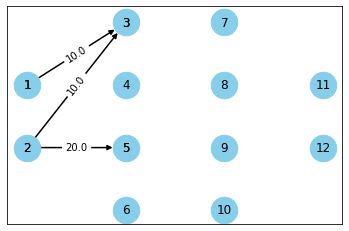


Los flujos a operar en el tiempo 2 son:


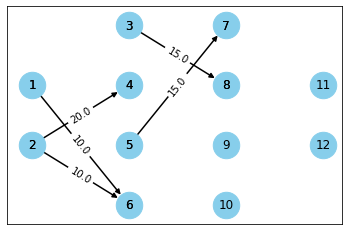


Los flujos a operar en el tiempo 3 son:


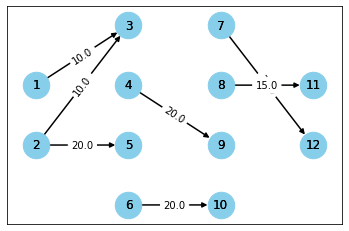

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1

Los flujos a operar en el tiempo 4 son:


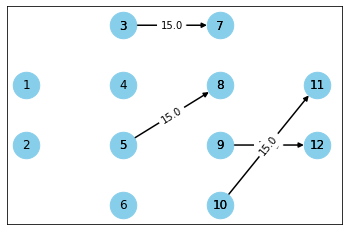

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1

Los flujos a operar en el tiempo 5 son:


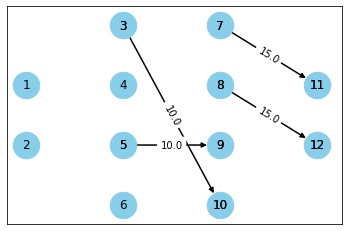

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1

Los flujos a operar en el tiempo 6 son:


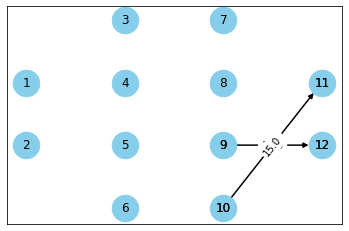

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1



In [6]:
#Resultados
x = [1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4]
y = [3, 2, 4, 3, 2, 1, 4, 3, 2, 1, 3, 2]
pos = {(i+1):(x[i],y[i]) for i in range(len(N))}


if numx != numflujos:
    print('OJOOOOO que Xs',numx, 'y Fs',numflujos)

else:
    print('OK')

for t in T:
    print('Los flujos a operar en el tiempo',t, 'son:')
    arcs = []
    flows = []
    for nn in A:
        if F[nn,t].x >= 0.01:
            arcs.append(((nn)))
            flows.append(round(F[nn,t].x,2))
            
    graph = nx.DiGraph()
    for i in range(len(arcs)):
        graph.add_edge(arcs[i][0],arcs[i][1])
 
    pairs = list(zip(list(arcs),list(flows)))
    edgelabels = dict(pairs)
    
    nodelabels = {i:str(i) for i in range(1,len(N)+1)}
    
    nx.draw_networkx(graph,pos,node_size=700,node_color='skyblue',width=1.5,nodelist=list(range(1,len(N)+1)), with_labels=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edgelabels)
    nx.draw_networkx_labels(graph,pos,nodelabels)
    plt.show()
    if t > 1:
        for d in D:
            for b2 in B2:
                if F[(b2,d),t].x >= 0.1:
                    for q in Q:
                        print('La concentración que salio por',d,'es',round(C[q,b2,t-1].x,2),'que debe estar entre',CL_qd[q,d],'y',CU_qd[q,d])
    print() 

In [9]:
for t in T:
    for b in B:
        if YB[b,t].x > 0:
            print('El tanque',b,'en el tiempo',t,'estaba cargando')

El tanque 3 en el tiempo 1 estaba cargando
El tanque 4 en el tiempo 1 estaba cargando
El tanque 5 en el tiempo 1 estaba cargando
El tanque 6 en el tiempo 1 estaba cargando
El tanque 4 en el tiempo 2 estaba cargando
El tanque 6 en el tiempo 2 estaba cargando
El tanque 7 en el tiempo 2 estaba cargando
El tanque 8 en el tiempo 2 estaba cargando
El tanque 9 en el tiempo 2 estaba cargando
El tanque 10 en el tiempo 2 estaba cargando
El tanque 3 en el tiempo 3 estaba cargando
El tanque 5 en el tiempo 3 estaba cargando
El tanque 9 en el tiempo 3 estaba cargando
El tanque 10 en el tiempo 3 estaba cargando
El tanque 4 en el tiempo 4 estaba cargando
El tanque 6 en el tiempo 4 estaba cargando
El tanque 7 en el tiempo 4 estaba cargando
El tanque 8 en el tiempo 4 estaba cargando
El tanque 9 en el tiempo 5 estaba cargando
El tanque 10 en el tiempo 5 estaba cargando
El tanque 5 en el tiempo 6 estaba cargando
El tanque 6 en el tiempo 6 estaba cargando
